In [1]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import os
import numpy as np


In [2]:
import pandas as pd
import os

def load_and_clean_classification_data(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No se encontró el archivo en: {file_path}")
    
    df = pd.read_csv(file_path)
    
    if 'autoID' in df.columns:
        df = df.drop(columns=['autoID'])
    
    cols_to_fix = ['Demand', 'Charges']
    for col in cols_to_fix:
        if col in df.columns:
            df[col] = (
                df[col]
                .astype(str)
                .str.replace('.', '', regex=False)
                .replace('nan', np.nan) 
            )
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    df['Demand'] = df['Demand'].fillna(df['Demand'].median())
    df['Charges'] = df['Charges'].fillna(df['Charges'].median())

    if 'Class' in df.columns:
        df['Class'] = df['Class'].str.strip()
    
    return df

DATA_PATH_ML = os.path.join('..', 'data', 'dataset_alpha_betha.csv')

try:
    df_ml = load_and_clean_classification_data(DATA_PATH_ML)
    print("Dataset de clasificación cargado y limpio.")
    print(f"Dimensiones: {df_ml.shape}")
    print("\nConteo de clases:\n", df_ml['Class'].value_counts())
except Exception as e:
    print(f"Error crítico: {e}")

Dataset de clasificación cargado y limpio.
Dimensiones: (7043, 15)

Conteo de clases:
 Class
Alpha    5174
Betha    1869
Name: count, dtype: int64


In [3]:
categorical_features = [
    'SeniorCity', 'Partner', 'Dependents', 'Service1', 'Service2', 
    'Security', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]


numeric_features = ['Charges', 'Demand']

target = 'Class'

print(f"Dataset listo para procesar: {df_ml.shape[0]} registros y {df_ml.shape[1]} columnas.")

X = df_ml.drop(columns=[target])
y = df_ml[target]

print("Características (X) y Etiquetas (y) separadas correctamente.")

Dataset listo para procesar: 7043 registros y 15 columnas.
Características (X) y Etiquetas (y) separadas correctamente.


In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder
import joblib
import os

le = LabelEncoder()
y = le.fit_transform(y) 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

X = df_ml.drop(columns=[target])
y = df_ml[target]

X_transformed = preprocessor.fit_transform(X)

encoded_cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(encoded_cat_names)

df_transformed = pd.DataFrame(X_transformed, columns=all_feature_names)

print("\n--- Vista de los datos transformados ---")
print(df_transformed.head())


--- Vista de los datos transformados ---
    Charges    Demand  SeniorCity_1  Partner_Yes  Dependents_Yes  \
0 -0.156695 -0.639983           0.0          1.0             0.0   
1  0.594685 -0.557287           0.0          0.0             0.0   
2  0.508734 -0.599284           0.0          0.0             0.0   
3 -0.867040  0.301276           0.0          0.0             0.0   
4 -0.788298 -0.576674           0.0          0.0             0.0   

   Service1_Yes  Service2_No phone service  Service2_Yes  \
0           0.0                        1.0           0.0   
1           1.0                        0.0           0.0   
2           1.0                        0.0           0.0   
3           0.0                        1.0           0.0   
4           1.0                        0.0           0.0   

   Security_No internet service  Security_Yes  ...  \
0                           0.0           0.0  ...   
1                           0.0           1.0  ...   
2                         

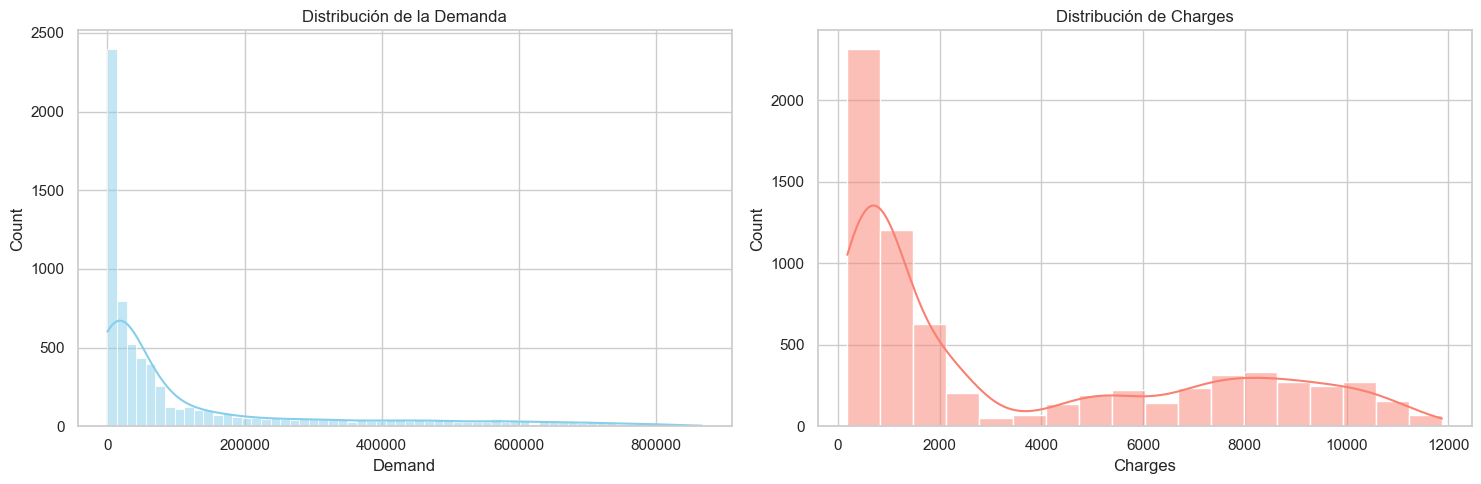

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df_ml['Demand'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribución de la Demanda')

sns.histplot(df_ml['Charges'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribución de Charges')

plt.tight_layout()
plt.show()

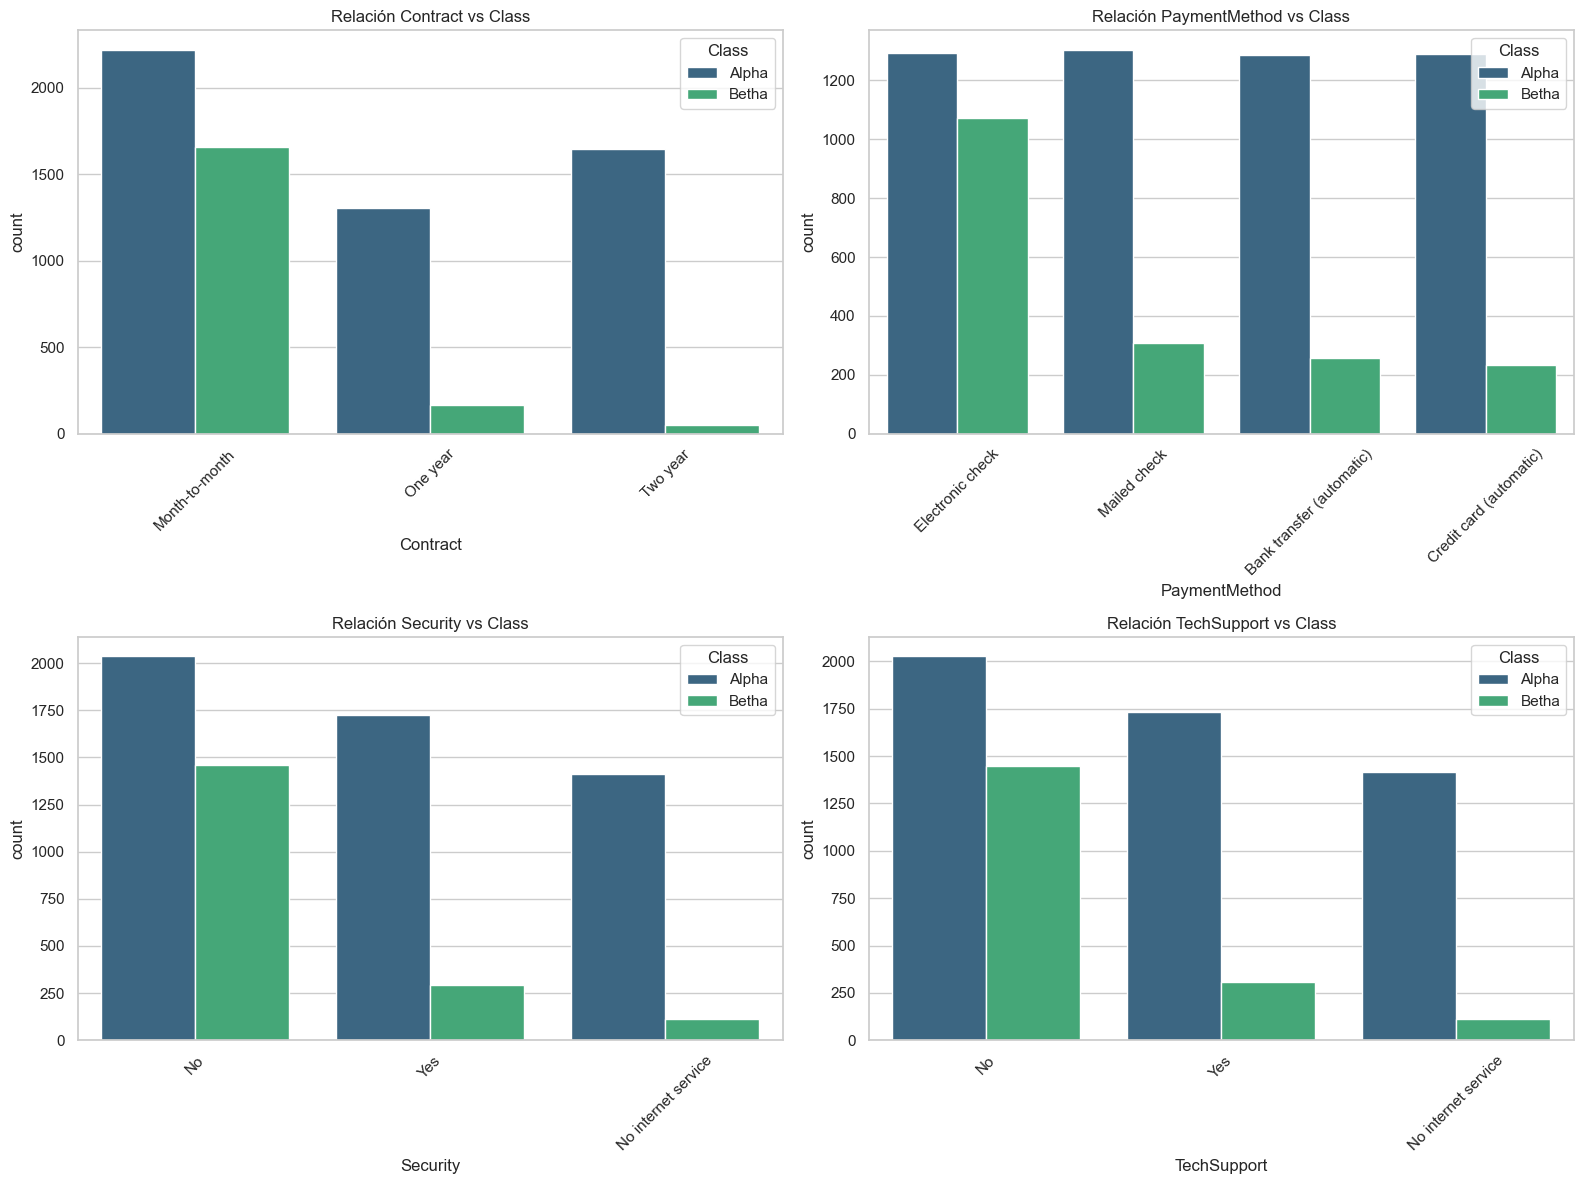

In [8]:
cols_to_plot = ['Contract', 'PaymentMethod', 'Security', 'TechSupport']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    sns.countplot(data=df_ml, x=col, hue='Class', ax=axes[i], palette='viridis')
    axes[i].set_title(f'Relación {col} vs Class')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib


X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.20, random_state=42, stratify=y
)


model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=15, 
    class_weight='balanced', 
    random_state=42
)

model.fit(X_train, y_train)


y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print(f" Modelo entrenado. Accuracy: {acc:.4f}")
print("\nReporte de Clasificación:\n", report)

 Modelo entrenado. Accuracy: 0.7686

Reporte de Clasificación:
               precision    recall  f1-score   support

       Alpha       0.84      0.84      0.84      1035
       Betha       0.56      0.57      0.57       374

    accuracy                           0.77      1409
   macro avg       0.70      0.71      0.70      1409
weighted avg       0.77      0.77      0.77      1409



In [22]:
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(model, 'models/rf_model.pkl')
joblib.dump(preprocessor, 'models/preprocessor.pkl')
joblib.dump(le, 'models/label_encoder.pkl')

print("✅ Todos los componentes han sido exportados exitosamente.")

✅ Todos los componentes han sido exportados exitosamente.
